## Dependencias

In [139]:
!pip install giotto-tda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [140]:
!pip install gudhi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
import pandas as pd
import numpy as np
import numpy as np
import gudhi as gd  
from sklearn import manifold
from pylab import *
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
%matplotlib inline
# import sklearn_tda


### Importar datos

In [142]:
object=pd.read_pickle('uke_eggedal_data_challenge.pkl')
df=pd.DataFrame.from_dict(object,orient='index')

In [143]:
df=df.T
df

,flow,obs_tas,flow_dates,obs_lon_lat,obs_pr,obs_dates
0,1.723781,"[-10.600000381469727, -9.699999809265137, -6.6...",1958-01-04,9.37,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000...",1957-01-01
1,0.960882,"[-20.5, -19.100000381469727, -12.0, -17.700000...",1958-01-05,60.23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20000000...",1957-01-02
2,0.001,"[-23.600000381469727, -22.5, -15.1000003814697...",1958-01-06,None,"[0.10000000149011612, 0.0, 0.30000001192092896...",1957-01-03
3,0.001,"[-16.200000762939453, -16.0, -14.1000003814697...",1958-01-07,None,"[1.0, 0.0, 1.0, 1.100000023841858, 0.899999976...",1957-01-04
4,0.316796,"[-7.900000095367432, -7.800000190734863, -9.5,...",1958-01-08,None,"[9.300000190734863, 8.600000381469727, 8.0, 8....",1957-01-05
...,...,...,...,...,...,...
21541,1.812796,"[-12.5, -11.699999809265137, -8.60000038146972...",2016-12-26,None,"[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27
21542,None,"[-12.5, -11.899999618530273, -9.10000038146972...",NaT,None,"[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28
21543,None,"[-11.899999618530273, -11.399999618530273, -8....",NaT,None,"[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29
21544,None,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...",NaT,None,"[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30


### Hay un desface en la data, se separan en df_target y df predic, se usa merge con date como llave

In [144]:
df_target=df[['flow_dates','flow']]
df_target.sort_values(by='flow_dates')
df_target=df_target.dropna()
df_target

,flow_dates,flow
0,1958-01-04,1.723781
1,1958-01-05,0.960882
2,1958-01-06,0.001
3,1958-01-07,0.001
4,1958-01-08,0.316796
...,...,...
21537,2016-12-22,4.84329
21538,2016-12-23,3.75697
21539,2016-12-24,3.556818
21540,2016-12-25,3.402133


In [145]:
df_predic=df[['obs_dates','obs_tas','obs_pr']]
df_predic.sort_values(by='obs_dates')
df_predic=df_predic.dropna()
df_predic


,obs_dates,obs_tas,obs_pr
0,1957-01-01,"[-10.600000381469727, -9.699999809265137, -6.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000..."
1,1957-01-02,"[-20.5, -19.100000381469727, -12.0, -17.700000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20000000..."
2,1957-01-03,"[-23.600000381469727, -22.5, -15.1000003814697...","[0.10000000149011612, 0.0, 0.30000001192092896..."
3,1957-01-04,"[-16.200000762939453, -16.0, -14.1000003814697...","[1.0, 0.0, 1.0, 1.100000023841858, 0.899999976..."
4,1957-01-05,"[-7.900000095367432, -7.800000190734863, -9.5,...","[9.300000190734863, 8.600000381469727, 8.0, 8...."
...,...,...,...
21541,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100..."
21542,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6...."
21543,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099..."
21544,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5...."


### Se hace el merge tomando como llaves las fechas, el resultado es un df con fechas que ya hacen match

In [146]:
df_final=df_predic.merge(df_target,how='inner',left_on='obs_dates',right_on='flow_dates')
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796
...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777


### Climate AI sugiere usar o PCA o simplemente promediar los datos vectorizados en lugar de tratarlos como variables distintas

In [147]:
df_final['temperatures'] = df_final['obs_tas'].apply(lambda x: np.mean(x))
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow,temperatures
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781,-12.655556
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882,-7.722222
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001,-8.088889
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001,-10.122222
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796,-17.455555
...,...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704,-9.944444
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625,-10.288889
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884,-9.411111
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777,-5.055556


In [148]:
df_final['precipitations'] = df_final['obs_pr'].apply(lambda x: np.mean(x))
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow,temperatures,precipitations
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781,-12.655556,0.000000
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882,-7.722222,2.588889
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001,-8.088889,12.766667
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001,-10.122222,6.877778
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796,-17.455555,3.411111
...,...,...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704,-9.944444,0.555556
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625,-10.288889,4.888889
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884,-9.411111,1.277778
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777,-5.055556,3.444444


## Inicia el TDA

In [149]:
max_embedding_dimension = 10
max_time_delay = 20
stride = 30

embedder_periodic = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)


In [150]:
def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
        )

    return y_embedded

#### Incrustacion y plot de componentes principales de precipitaciones

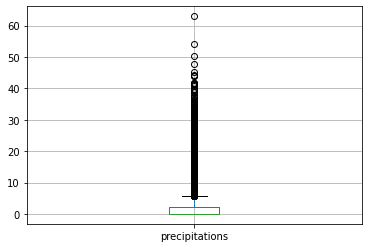

In [151]:
df_final.boxplot('precipitations')

In [152]:
precipitacion_embedded = fit_embedder(embedder_periodic, df_final['precipitations'])

Shape of embedded time series: (702, 8)
Optimal embedding dimension is 8 and time delay is 18


In [153]:
pca = PCA(n_components=3)
precipitacion_embedded_pca = pca.fit_transform(precipitacion_embedded)
plot_point_cloud(precipitacion_embedded_pca)

#### Incrustacion y plot de componentes principales de temperaturas

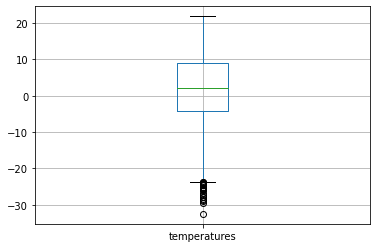

In [154]:
df_final.boxplot('temperatures')

In [155]:
temperatures_embedded = fit_embedder(embedder_periodic, df_final['temperatures'])
temperatures_embedded_pca = pca.fit_transform(temperatures_embedded)
plot_point_cloud(temperatures_embedded_pca)

Shape of embedded time series: (703, 6)
Optimal embedding dimension is 6 and time delay is 20


In [156]:
pca2 = PCA(n_components=2)
temperatures_embedded_pca2 = pca2.fit_transform(temperatures_embedded)
plot_point_cloud(temperatures_embedded_pca2)

### Diagrama de persistencia precipitation

In [157]:
precipitacion_embedded_VR = precipitacion_embedded_pca[None, :, :]
# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]
periodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for precipitation signal")
periodic_persistence.fit_transform_plot(precipitacion_embedded_VR)



Persistence diagram for precipitation signal


array([[[0.        , 0.00646915, 0.        ],
        [0.        , 0.00683288, 0.        ],
        [0.        , 0.01813306, 0.        ],
        ...,
        [0.80347204, 0.89257169, 2.        ],
        [0.6042583 , 0.60644096, 2.        ],
        [0.57617873, 0.58109176, 2.        ]]])

## Diagrama de persistencia temperatura

In [158]:
temperature_embedded_VR = temperatures_embedded_pca[None, :, :]
# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]
periodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for temperature signal")
periodic_persistence.fit_transform_plot(temperature_embedded_VR)



Persistence diagram for temperature signal


array([[[0.        , 0.30622774, 0.        ],
        [0.        , 0.34319532, 0.        ],
        [0.        , 0.38889953, 0.        ],
        ...,
        [3.54525518, 3.78725195, 2.        ],
        [3.53822351, 3.70624018, 2.        ],
        [3.53499532, 3.55671573, 2.        ]]])

## Discretización del problema 

In [159]:
def discretizador(clases: int=5):
  b=[]
  for i in range(clases):
    b.append(int(i*(df_final['flow'].max()-df_final['flow'].min())/clases))
  from math import ceil
  b.append(ceil(max(df_final['flow'])))
  b
  df_final['flow_discrete'] = pd.cut(x=df_final['flow'], bins=b,labels=
                                     list(range(clases)))

In [160]:
clases=5
discretizador(clases)
df_final['flow_discrete'].value_counts()

0    18741
1     1829
2      451
3      133
4       24
Name: flow_discrete, dtype: int64

In [161]:
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow,temperatures,precipitations,flow_discrete
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781,-12.655556,0.000000,0
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882,-7.722222,2.588889,0
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001,-8.088889,12.766667,0
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001,-10.122222,6.877778,0
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796,-17.455555,3.411111,0
...,...,...,...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704,-9.944444,0.555556,0
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625,-10.288889,4.888889,0
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884,-9.411111,1.277778,0
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777,-5.055556,3.444444,0


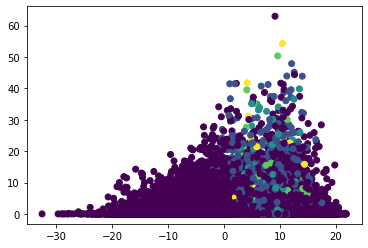

In [162]:
plt.scatter(x=df_final['temperatures'],y=df_final['precipitations'],c=df_final['flow_discrete'])

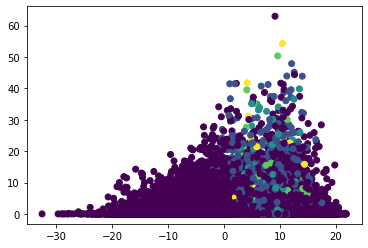

In [163]:
plt.scatter(x=df_final['temperatures'],y=df_final['precipitations'],c=df_final['flow_discrete'])

In [164]:
import plotly.express as px
fig = px.scatter_3d(df_final, x=df_final['temperatures'], 
                    y=df_final['precipitations'], z=df_final['flow'],
              color=df_final['flow_discrete'])
fig.show()

# Intento, red neuronal clasificacion con 2 features de entrada

In [165]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
dummy_y = np_utils.to_categorical(df_final['flow_discrete'])
dummy_y.shape

(21178, 5)

In [166]:
dummy_y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [167]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     df_final[['temperatures','precipitations']], dummy_y, test_size=0.2, 
     random_state=42)

##### Pipe prepara datos

In [168]:
def pipe():
  X_train, X_test, y_train, y_test = train_test_split(
      df_final[['temperatures','precipitations']], dummy_y, test_size=0.2, 
      random_state=42)  

In [169]:
# define the keras model
model = Sequential()
model.add(Dense(5*clases,input_shape=(X_train.shape[1],),activation='linear'))
model.add(Dense(clases,activation='relu'))
model.add(Dense(clases, activation='softmax'))
model.summary()
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 25)                75        
                                                                 
 dense_13 (Dense)            (None, 5)                 130       
                                                                 
 dense_14 (Dense)            (None, 5)                 30        
                                                                 
Total params: 235
Trainable params: 235
Non-trainable params: 0
_________________________________________________________________


In [170]:
import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X_test,
                    y_test,
                    callbacks=[es],
                    epochs=8000000, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/8000000
339/339 [==============================] - 2s 3ms/step - loss: 0.4888 - accuracy: 0.7347 - val_loss: 0.3486 - val_accuracy: 0.8797
Epoch 2/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.2543 - accuracy: 0.8849 - val_loss: 0.1628 - val_accuracy: 0.8797
Epoch 3/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1457 - accuracy: 0.8849 - val_loss: 0.1414 - val_accuracy: 0.8797
Epoch 4/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1344 - accuracy: 0.8849 - val_loss: 0.1394 - val_accuracy: 0.8797
Epoch 5/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1325 - accuracy: 0.8849 - val_loss: 0.1379 - val_accuracy: 0.8797
Epoch 6/8000000
339/339 [==============================] - 1s 2ms/step - loss: 0.1318 - accuracy: 0.8849 - val_loss: 0.1372 - val_accuracy: 0.8797
Epoch 7/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1313 - accuracy: 0.8849 - val_loss: 0

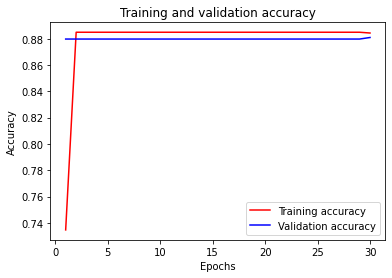

In [171]:
history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [172]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = model.predict(X_test) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1
matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))

[9.2093122e-01 5.3931389e-02 1.7578563e-02 7.5556757e-03 3.1692243e-06]
1.0
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3744
           1       0.00      0.00      0.00       378
           2       0.00      0.00      0.00        81
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00         1

    accuracy                           0.88      4236
   macro avg       0.18      0.20      0.19      4236
weighted avg       0.78      0.88      0.83      4236



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Intento, red neuronal clasificacion con 1 feature de entrada (CSM) precipitation

In [173]:
clases=5
discretizador(clases)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     df_final[['temperatures']], dummy_y, test_size=0.2, random_state=42)
# first neural network with keras tutorial
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

# define the keras model
model = Sequential()
model.add(Dense(10*clases,input_shape=(X_train.shape[1],),activation='linear'))
model.add(Dense(clases,activation='relu'))
model.add(Dense(clases, activation='softmax'))
model.summary()

# compile the keras model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                100       
                                                                 
 dense_16 (Dense)            (None, 5)                 255       
                                                                 
 dense_17 (Dense)            (None, 5)                 30        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [174]:
import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X_test,
                    y_test,
                    callbacks=[es],
                    epochs=8000000, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/8000000
339/339 [==============================] - 2s 4ms/step - loss: 0.3811 - accuracy: 0.6387 - val_loss: 0.1808 - val_accuracy: 0.8797
Epoch 2/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1443 - accuracy: 0.8849 - val_loss: 0.1400 - val_accuracy: 0.8797
Epoch 3/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1326 - accuracy: 0.8849 - val_loss: 0.1392 - val_accuracy: 0.8797
Epoch 4/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1307 - accuracy: 0.8849 - val_loss: 0.1393 - val_accuracy: 0.8797
Epoch 5/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1304 - accuracy: 0.8849 - val_loss: 0.1387 - val_accuracy: 0.8797
Epoch 6/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1306 - accuracy: 0.8849 - val_loss: 0.1404 - val_accuracy: 0.8797
Epoch 7/8000000
339/339 [==============================] - 1s 3ms/step - loss: 0.1301 - accuracy: 0.8849 - val_loss: 0

In [175]:
preds = model.predict(X_test) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1
matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))

[8.900936e-01 7.996418e-02 2.059044e-02 9.285449e-03 6.628728e-05]
0.99999994
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3744
           1       0.00      0.00      0.00       378
           2       0.00      0.00      0.00        81
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00         1

    accuracy                           0.88      4236
   macro avg       0.18      0.20      0.19      4236
weighted avg       0.78      0.88      0.83      4236



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Intento con transformacion de datos

### Lo primero es tratar de conocer si a grandes rasgos los datos siguen una distribucion conocida

In [176]:
pipe()


(array([18741.,     0.,  1829.,     0.,     0.,   451.,     0.,   133.,
            0.,    24.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

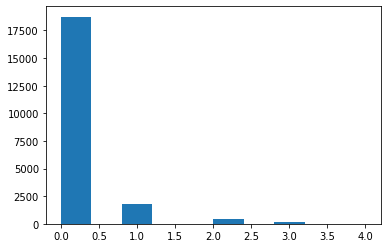

In [177]:
plt.hist(df_final['flow_discrete'])

(array([1.5854e+04, 2.9030e+03, 1.2650e+03, 5.5400e+02, 3.0900e+02,
        1.3900e+02, 9.4000e+01, 3.6000e+01, 1.8000e+01, 6.0000e+00]),
 array([3.1429202947519386e-05, 8.539793605569512, 17.07955578193608,
        25.619317958302645, 34.15908013466921, 42.698842311035776,
        51.23860448740234, 59.77836666376891, 68.31812884013547,
        76.85789101650204, 85.3976531928686], dtype=object),
 <a list of 10 Patch objects>)

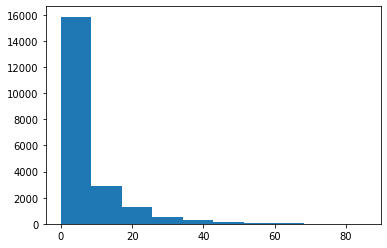

In [178]:
plt.hist(df_final['flow'])

In [179]:
from scipy import stats
y=df_final['flow']
x=df_final[['precipitations','temperatures']]

(array([1994.,  489., 2184., 5120., 4593., 3155., 2095., 1048.,  417.,
          83.]),
 array([-3.6154716 , -2.42187784, -1.22828408, -0.03469032,  1.15890344,
         2.3524972 ,  3.54609096,  4.73968472,  5.93327848,  7.12687224,
         8.320466  ]),
 <a list of 10 Patch objects>)

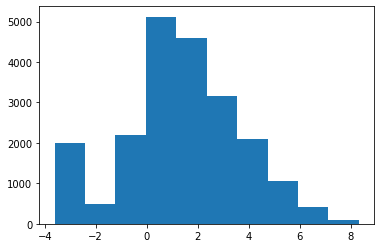

In [180]:
by, fitted_lambda = stats.boxcox(y.astype(float))
plt.hist(by)

(array([1.8756e+04, 1.5590e+03, 5.2500e+02, 2.1300e+02, 6.9000e+01,
        3.3000e+01, 1.7000e+01, 4.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <a list of 10 Patch objects>)

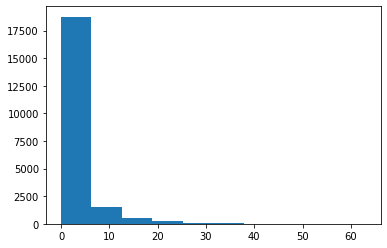

In [181]:
plt.hist(x['precipitations'])

In [182]:
x['precipitations']+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([11324.,   591.,   567.,   565.,   650.,   812.,   997.,  1459.,
         2081.,  2132.]),
 array([0.        , 0.09359049, 0.18718099, 0.28077148, 0.37436197,
        0.46795246, 0.56154296, 0.65513345, 0.74872394, 0.84231443,
        0.93590493]),
 <a list of 10 Patch objects>)

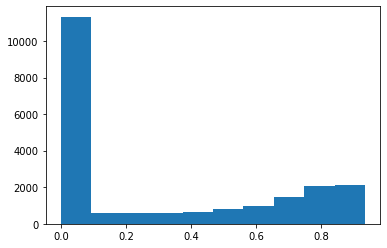

In [183]:
bx_1, fitted_lambda = stats.boxcox(x['precipitations'].astype(float))
plt.hist(bx_1)

(array([   9.,   56.,  417., 1236., 2692., 4474., 4358., 4526., 2923.,
         487.]), array([-32.51111073, -27.073333  , -21.63555527, -16.19777754,
        -10.75999981,  -5.32222207,   0.11555566,   5.55333339,
         10.99111112,  16.42888885,  21.86666658]), <a list of 10 Patch objects>)

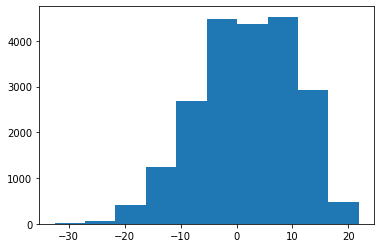

In [184]:
plt.hist(x['temperatures'])

In [185]:
x['temperatures']+=abs(min(x['temperatures']))+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([  40.,  454., 1390., 2769., 4141., 3849., 3453., 3552., 1315.,
         215.]), array([  0.        ,  18.04909065,  36.09818131,  54.14727196,
         72.19636262,  90.24545327, 108.29454392, 126.34363458,
        144.39272523, 162.44181589, 180.49090654]), <a list of 10 Patch objects>)

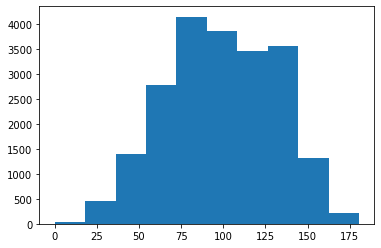

In [186]:
bx_2, fitted_lambda = stats.boxcox(x['temperatures'].astype(float))
plt.hist(bx_2)

## Re discretizamos, re etiquetamos y volvemos a crear visualizaciones

In [187]:
zipped = list(zip(bx_1,bx_2,y))
transformedDF=pd.DataFrame(zipped,columns=['Precipitations', 'Temperatures', 'flow'])
transformedDF

,Precipitations,Temperatures,flow
0,0.000000,46.611458,1.723781
1,0.701605,62.655246,0.960882
2,0.888115,61.419805,0.001000
3,0.840335,54.691242,0.001000
4,0.749739,32.314774,0.316796
...,...,...,...
21173,0.353138,55.271092,2.177040
21174,0.801756,54.149130,4.876250
21175,0.550110,57.020455,4.998840
21176,0.751305,71.835210,4.428777


In [188]:
def discretizador1(clases: int=5):
  b=[]
  for i in range(clases):
    b.append(int(i*(transformedDF['flow'].max()-transformedDF['flow'].min())/clases))
  from math import ceil
  b.append(ceil(max(transformedDF['flow'])))
  b
  transformedDF['flow_discrete'] = pd.cut(x=transformedDF['flow'], bins=b,labels=
                                     list(range(clases)))

In [189]:
discretizador1()

In [190]:
fig = px.scatter_3d(transformedDF, x=transformedDF['Temperatures'], 
                    y=transformedDF['Precipitations'], z=df_final['flow'],
              color=transformedDF['flow_discrete'])
fig.show()

Las transformaciones no parecen haber ayudado, el problema parece ser no linealmente separable, y no veo una manera clara de poder proyectar los datos en una dimension mas alta y que los datos si sean separables de esta manera

# Experientos de TDA como feature extraction

## Experimento 1, regresion logistica multiclase, no muy exitoso
Se tenian que resamplear los datos, en lugar de usar la librería, lo hice manualmente, probablemente esto causó el mal resultado en primer lugar

In [191]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding

embedding_dimension = 3
embedding_time_delay = 1
stride = 10

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)
# homology dimensions determina la dimension de la salida
persistence = VietorisRipsPersistence(homology_dimensions=list(range(10)), n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)


steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]
topological_transfomer = Pipeline(steps)

In [192]:
X=df_final[['precipitations']].to_numpy()

X=X[:-658]
# redimensiono para tener una matriz de meses lecturas
X=X.reshape(57*12,-1)
X.shape


(684, 30)

In [193]:
features = topological_transfomer.fit_transform(X)


/usr/local/lib/python3.7/dist-packages/gtda/homology/simplicial.py:233: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

/usr/local/lib/python3.7/dist-packages/gtda/homology/simplicial.py:300: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.



In [194]:
features.shape

(684, 10)

In [195]:
X1=df_final[['precipitations']].to_numpy()
X1=X1[:-658]

X1=X1.reshape(57*12,-1)
X1.shape

(684, 30)

In [196]:
features1 = topological_transfomer.fit_transform(X1)

/usr/local/lib/python3.7/dist-packages/gtda/homology/simplicial.py:233: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

/usr/local/lib/python3.7/dist-packages/gtda/homology/simplicial.py:300: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.



In [197]:
features1.shape

(684, 10)

In [198]:
df_final_=df_final[:-658]
df_final_

,obs_dates,obs_tas,obs_pr,flow_dates,flow,temperatures,precipitations,flow_discrete
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781,-12.655556,0.000000,0
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882,-7.722222,2.588889,0
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001,-8.088889,12.766667,0
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001,-10.122222,6.877778,0
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796,-17.455555,3.411111,0
...,...,...,...,...,...,...,...,...
20515,2014-03-09,"[-1.2999999523162842, -0.4000000059604645, 3.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2014-03-09,2.937076,1.233333,0.000000,0
20516,2014-03-10,"[1.399999976158142, 2.200000047683716, 5.59999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1000000014901...",2014-03-10,3.604633,3.588889,0.011111,0
20517,2014-03-11,"[-1.7999999523162842, -0.800000011920929, 2.70...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2014-03-11,5.694376,0.811111,0.000000,0
20518,2014-03-12,"[0.6000000238418579, 1.5, 4.400000095367432, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2014-03-12,5.100338,2.922222,0.000000,0


In [199]:
targetMeanV=[]
for i in range(684):
  curr=df_final[(i)*30:(i+1)*30]
  targetMeanV.append(curr['flow'].mean())

In [200]:
ditifrimi = pd.DataFrame(targetMeanV)
ditifrimi.columns=['Target']
ditifrimi


,Target
0,0.604588
1,0.667598
2,0.451580
3,5.564475
4,17.305299
...,...
679,7.037147
680,2.762741
681,3.611898
682,2.382954


In [201]:
b=[]
import math
for i in range(10):
  b.append(math.floor((i*ditifrimi['Target'].max()-ditifrimi['Target'].min())/10))
b

[-1, 4, 9, 14, 19, 24, 28, 33, 38, 43]

In [202]:
ditifrimi['Target_discrete'] = pd.cut(x=ditifrimi['Target'], bins=b,
                     labels=list(range(1,10)))

In [203]:
ditifrimi=ditifrimi.drop([308])
features=np.delete(features, 308, axis=0)

In [204]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(
    features, ditifrimi['Target_discrete'], test_size=0.1, random_state=42
)

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='ovr')
model.fit(X_train, y_train)

# evaluate multinomial logistic regression model
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=30, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_test,y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in

Mean Accuracy: 0.533 (0.060)
